# SU(3) Normalizing Flow

This tutorial demonstrates how to train a potential-based normalizing flow to learn conjugation-invariant target distributions on SU(3). 

## Mathematical Background

We work with SU(3), and the target density has the form:

$$p(U) \propto \exp\left(-\beta \sum_{i=1}^3 c_i \text{Re}[\text{tr}(U^i)]\right)$$

This density is conjugation-invariant: $p(VUV^\dagger) = p(U)$ for any $V \in \text{SU}(3)$.

## Setup and Imports

We start by importing the necessary libraries and setting up our configuration.

In [ ]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import matplotlib.pyplot as plt
import numpy as np
from jax_autovmap import autovmap
from functools import partial
from IPython.display import clear_output
from tqdm import tqdm

import bijx

# Configuration
config = {
    'group_n': 3,
    'generators': bijx.lie.SU3_GEN,
    'target_beta': 9.0,  # Inverse coupling strength
    'target_coefficients': [0.17, -0.65, 1.22],  # Wilson action coefficients
    'grid_points': 30,  # For visualization
    'batch_size': 100,
    'learning_rate': 1e-3,
    'ema_rate': 0.99,
    'max_steps': 200,
    'rng_seed': 42,
}

rngs = nnx.Rngs(config['rng_seed'])
print(f"Configuration: SU({config['group_n']}) with β={config['target_beta']}")

Configuration: SU(3) with β=9.0


## Target Density Definition

We define our target density based on a Wilson-like gauge action. This creates a physics-motivated distribution that respects the conjugation symmetry of SU(3).

In [32]:
def define_target_density(beta, coefficients):
    """Define conjugation-invariant target density for SU(3)."""
    def target_log_density(U):
        log_prob = 0.0
        U_power = None

        for i, coeff in enumerate(coefficients, 1):
            if U_power is None:
                U_power = U  # U^1
            else:
                U_power = jnp.einsum('...ij,...jk->...ik', U_power, U)  # U^i

            trace_term = jnp.trace(U_power, axis1=-2, axis2=-1)
            log_prob += beta / U.shape[-1] * coeff * trace_term.real

        return log_prob

    return target_log_density

# Create target density
target_log_density = define_target_density(config['target_beta'], config['target_coefficients'])

In [33]:
# Test conjugation invariance
test_matrices = bijx.lie.sample_haar(rngs(), n=3, batch_shape=(5,))
V = bijx.lie.sample_haar(rngs(), n=3)
original_logp = target_log_density(test_matrices)
conjugated = jnp.einsum('ij,...jk,lk->...il', V, test_matrices, V.conj())
conjugated_logp = target_log_density(conjugated)
max_diff = jnp.max(jnp.abs(original_logp - conjugated_logp))

print(f"Conjugation invariance test: max |p(U) - p(VUV†)| = {max_diff:.2e}")
print(f"Log-density range: [{jnp.min(original_logp):.2f}, {jnp.max(original_logp):.2f}]")

Conjugation invariance test: max |p(U) - p(VUV†)| = 3.81e-06
Log-density range: [3.45, 11.30]


## Target Density Visualization

Let's visualize our target density in eigenvalue coordinates to see what our neural network will learn to sample from.

For convenience, we will first define a general, reusable plotting function for this that works for SU(2) and SU(3).

In [34]:
from bijx.lie import evaluate_density_on_eigenvalue_grid

def plot_su_density(
    density_fn,
    n=2,
    grid_points=200,
    rng=None,
    fig=None,
    **plot_kwargs
):
    """Plot probability density on SU(N) group using eigenvalue coordinates.

    Creates visualizations of probability densities on SU(N)
    groups by evaluating the density in eigenvalue angle coordinates and
    properly accounting for the Haar measure.

    For SU(2): Creates a 1D line plot of density vs. eigenvalue angle
    For SU(3): Creates a 2D heatmap of density vs. two eigenvalue angles
    For N ≥ 4: Raises error (too high-dimensional for visualization)

    Args:
        density_fn: Function mapping SU(N) matrices to density values.
            Should accept arrays of shape (..., n, n) and return shape (...,).
        n: Dimension of SU(N) group (2 or 3 supported for plotting).
        grid_points: Resolution of the eigenvalue grid.
        rng: Random key for matrix construction. If None, uses fixed seed.
        fig: Matplotlib figure to plot on. If None, creates new figure.
        **plot_kwargs: Additional arguments passed to plt.plot() (SU(2)) or
            plt.imshow() (SU(3)).

    Returns:
        matplotlib figure object containing the plot.

    Example:
        >>> def wilson_action(U, beta=2.0):
        ...     # Example: Wilson gauge action
        ...     return beta * jnp.real(jnp.trace(U, axis1=-2, axis2=-1))
        >>>
        >>> # Plot SU(2) density
        >>> fig1 = plot_su_density(wilson_action, n=2, grid_points=200)
        >>> fig1.savefig('su2_density.pdf')
        >>>
        >>> # Plot SU(3) density with custom colormap
        >>> fig2 = plot_su_density(wilson_action, n=3, grid_points=100,
        ...                        cmap='viridis', vmin=0.01)
        >>> fig2.savefig('su3_density.pdf')

    Note:
        - Densities are automatically normalized and weighted by Haar measure
        - For SU(3), uses logarithmic scaling to handle large dynamic range
        - Axes are labeled with proper mathematical notation
        - Returns figure object for further customization or saving
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm

    if n > 3:
        raise ValueError(f"Visualization not supported for SU({n}) with n > 3")

    if rng is None:
        rng = jax.random.PRNGKey(0)

    if fig is None:
        fig = plt.figure(figsize=(8, 6) if n == 2 else (8, 8))

    # Evaluate density on eigenvalue grid
    angles, density_values, haar_weights = evaluate_density_on_eigenvalue_grid(
        density_fn, n, grid_points, rng, normalize=True
    )

    # Apply Haar measure weighting
    weighted_density = density_values * haar_weights

    if n == 2:
        # 1D plot for SU(2)
        plt.plot(angles.squeeze(), weighted_density, **plot_kwargs)
        plt.xlabel(r'Eigenvalue angle $\theta$')
        plt.ylabel('Density')
        plt.title(f'SU(2) Density Distribution')
        plt.grid(True, alpha=0.3)

    elif n == 3:
        # 2D heatmap for SU(3)
        angles_2d = angles.reshape(grid_points, grid_points, 2)
        density_2d = weighted_density.reshape(grid_points, grid_points)

        # Use log scale for better visualization
        plot_kwargs.setdefault('norm', LogNorm(vmin=jnp.max(density_2d)*1e-5,
                                              vmax=jnp.max(density_2d)))
        plot_kwargs.setdefault('origin', 'lower')
        plot_kwargs.setdefault('extent', (-jnp.pi, jnp.pi, -jnp.pi, jnp.pi))
        plot_kwargs.setdefault('cmap', 'hot')

        im = plt.imshow(jnp.clip(density_2d, jnp.max(density_2d)*1e-5,
                                jnp.max(density_2d)), **plot_kwargs)
        plt.colorbar(im, label='Density')
        plt.xlabel(r'Eigenvalue angle $\theta_1$')
        plt.ylabel(r'Eigenvalue angle $\theta_2$')
        plt.title(f'SU(3) Density Distribution')

    plt.tight_layout()
    return fig

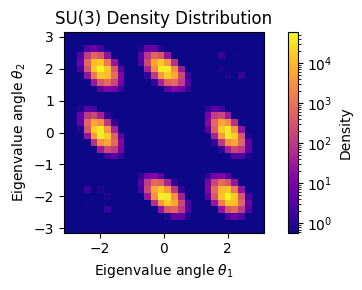

In [35]:
# Create visualization
def target_density_for_plot(U):
    return jnp.exp(target_log_density(U))

fig = plt.figure(figsize=(5, 3))
fig = plot_su_density(
    target_density_for_plot,
    n=3,
    grid_points=config['grid_points'],
    rng=rngs(),
    fig=fig,
    cmap='plasma'
)

plt.tight_layout()

plt.show()

## Neural Network Architecture

We define a neural network that learns a scalar potential on SU(3) matrices. The key insight is to use **trace-based features** that respect the conjugation symmetry: $\text{tr}(VUV^\dagger) = \text{tr}(U)$ for any $V \in \text{SU}(3)$.

In [36]:
class Potential(nnx.Module):
    """Neural network potential with conjugation-invariant features."""

    def __init__(self, n=3, feature_pow=4, width=128, depth=3, *, rngs):
        self.width = width
        self.n = n
        self.feature_pow = feature_pow

        # Time embedding for continuous flows
        self.t_emb = nnx.Sequential(
            nnx.Linear(
                1, 64, kernel_init=nnx.initializers.uniform(1),
                bias_init=nnx.initializers.uniform(2*jnp.pi), rngs=rngs
            ),
            jnp.sin,
            nnx.Linear(64, 64, rngs=rngs)
        )

        # Feature processing
        features_per_power = 6 if feature_pow > 2 else 5
        total_features = features_per_power * feature_pow + 64

        self.project_in = nnx.Linear(total_features, width, rngs=rngs)
        self.layers = [nnx.Linear(width, width, rngs=rngs) for _ in range(depth)]
        self.proj_out = nnx.Linear(width, 1, kernel_init=nnx.initializers.normal(1e-3), rngs=rngs)

    def __call__(self, t, y):
        # Time embedding
        t_emb = self.t_emb(jnp.reshape(t, (1, 1)))

        # Extract trace features
        features = self._extract_trace_features(y)

        # Process through network
        x = jnp.concatenate((features.reshape(1, -1) / jnp.sqrt(self.width), t_emb), -1)
        x = self.project_in(x)

        for layer in self.layers:
            x = x + layer(nnx.gelu(x))

        return self.proj_out(x).squeeze() / jnp.sqrt(self.width)

    def _extract_trace_features(self, y):
        """Extract conjugation-invariant features from matrix powers."""
        features = []
        U_power = None

        for power in range(1, self.feature_pow + 1):
            if U_power is None:
                U_power = y
            else:
                U_power = U_power @ y

            tr = jnp.trace(U_power)
            x1, x2, x3 = map(lambda x: x.reshape(1, 1), (tr.real, tr.imag, jnp.abs(tr)))

            if self.feature_pow > 2:
                power_features = [x1, x2, x3, x1**2, x2**2, x3**2]
            else:
                power_features = [x1, x2, x3, x1**2, x2**2]

            features.extend(power_features)

        return jnp.concatenate(features, axis=0)

In [ ]:
# Create and test the network
potential = Potential(n=config['group_n'], rngs=rngs)

Note that the above hyperparameter choices are mostly for demonstration purposes.
A larger network, and tuning the learning rate (decay) as well as number of steps can improve the final performance achieved below.

In [38]:
# Quick test
identity = jnp.eye(config['group_n'], dtype=complex)
test_val = potential(0.5, identity)
print(f"Network created with {sum(jnp.size(p) for p in jax.tree.leaves(nnx.state(potential))):,} parameters")
print(f"Test evaluation: φ(0.5, I) = {test_val:.4f}")

Network created with 65,345 parameters
Test evaluation: φ(0.5, I) = 0.0002


In [39]:
# define a vector field given potential

class AutoVF(nnx.Module):
    def __init__(self, potential):
        self.potential = potential

    @autovmap(t=0, u=2)
    def __call__(self, t, u):
        _, vec, div = bijx.lie.value_grad_divergence(partial(self.potential, t), u, bijx.lie.SU3_GEN)
        return vec, -div

vector_field = AutoVF(potential)

In [40]:
# evaluate vector field
vector_field(.1, jnp.eye(3, dtype=complex)[None])

(Array([[[0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j]]], dtype=complex64),
 Array([0.01306146], dtype=float32))

In [41]:
flow = bijx.ContFlowCG(vector_field, tableau=bijx.cg.CG2)
model = bijx.Transformed(
    bijx.lie.HaarDistribution(3, rngs=nnx.Rngs(42)),
    flow,
)

In [42]:
model.sample()

(Array([[-0.18605974+0.25039056j, -0.5730911 -0.24799211j,
          0.58821166+0.40836257j],
        [-0.37099373+0.75925255j, -0.12590973+0.20304114j,
         -0.47835037+0.00105148j],
        [ 0.43137515-0.05001021j, -0.6170116 -0.4150711j ,
         -0.42831483-0.27381313j]], dtype=complex64),
 Array(-0.00275824, dtype=float32))

## Training Infrastructure

We set up the training infrastructure including the loss function, optimizer, and training state management.

In [43]:
class TrainingState(nnx.Module):
    """Training state with exponential moving average."""
    def __init__(self, model, optimizer, ema_rate=0.99):
        self.model = model
        self.optimizer = nnx.Optimizer(model, optimizer, wrt=nnx.Param)
        self.ema_rate = ema_rate
        self.model_ema = nnx.clone(model)

    def _update_ema(self):
        current_state = nnx.state(self.model, nnx.Param)
        ema_state = nnx.state(self.model_ema, nnx.Param)
        new_ema_state = jax.tree.map(
            lambda p_ema, p: p_ema * self.ema_rate + p * (1. - self.ema_rate),
            ema_state, current_state
        )
        nnx.update(self.model_ema, new_ema_state)

    def update(self, grads):
        self.optimizer.update(self.model, grads)
        self._update_ema()


In [44]:
def loss_fn(model, batch_size):
    u, proposal = model.sample(batch_size)
    target = target_log_density(u)
    # reverse KL divergence
    return jnp.mean(proposal - target)

@partial(nnx.jit, static_argnums=(1,))
def training_step(state, batch_size):
    loss, grads = nnx.value_and_grad(loss_fn)(state.model, batch_size)
    state.update(grads)
    return loss

In [45]:
# Initialize training state
optimizer = optax.adam(config['learning_rate'])
train_state = TrainingState(model, optimizer, config['ema_rate'])

## Training Loop

Now we train our normalizing flow. The training loop demonstrates how the model learns to match the target density through gradient-based optimization.

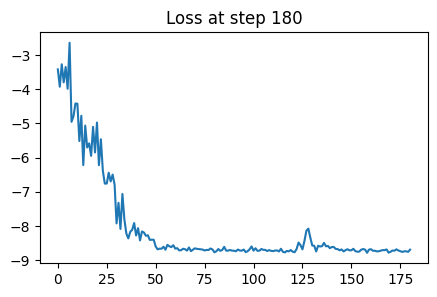

100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


In [46]:
# Training loop
losses = np.full(config['max_steps'], np.nan)

for step in tqdm(range(config['max_steps'])):
    losses[step] = training_step(train_state, (config['batch_size'],))

    if step % 20 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(5, 3))
        plt.plot(losses[:step+1])
        plt.title(f"Loss at step {step}")
        plt.show()


## Results Analysis

Let's analyze how well our trained model performs by comparing its predictions with the target density.

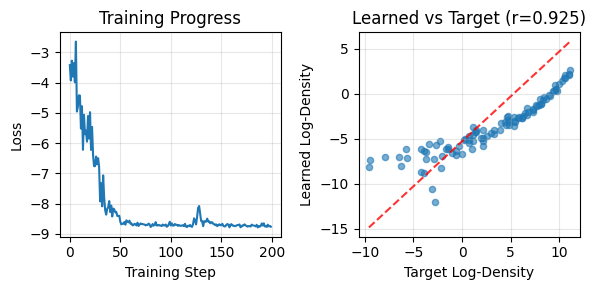


Density Comparison:


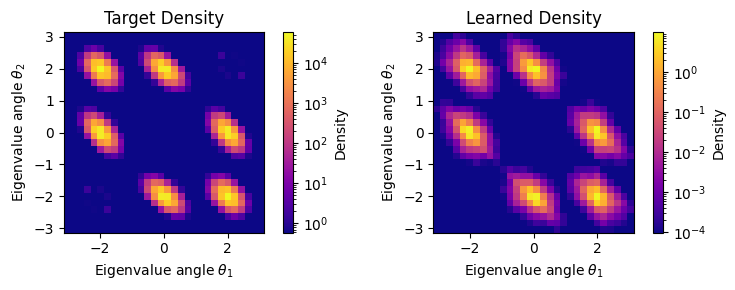

In [49]:
# Evaluate model performance
test_matrices = bijx.lie.sample_haar(rngs(), n=config['group_n'], batch_shape=(100,))
target_values = target_log_density(test_matrices)
learned_values = train_state.model.log_density(test_matrices)

# Compute metrics
correlation = jnp.corrcoef(learned_values, target_values)[0, 1]

# Plot training progress and correlation
fig = plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(target_values, learned_values, alpha=0.6, s=20)
# Fit linear regression
coef = jnp.polyfit(target_values, learned_values, 1)
x_line = jnp.array([target_values.min(), target_values.max()])
y_line = x_line + coef[1]
plt.plot(x_line, y_line, 'r--', alpha=0.8)
plt.xlabel('Target Log-Density')
plt.ylabel('Learned Log-Density')
plt.title(f'Learned vs Target (r={correlation:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create density comparison plots
print("\nDensity Comparison:")

# Plot target density
fig1 = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plot_su_density(
    target_density_for_plot,
    n=3,
    grid_points=config['grid_points'],
    rng=rngs(),
    fig=fig1,
    cmap='plasma'
)
plt.title('Target Density')

# Create learned density function that works with bijx plotting
def learned_density_safe(U):
    try:
        # Handle both single matrices and batches
        if U.ndim == 2:  # Single matrix
            log_density = train_state.model.log_density(U)
            # Ensure it's a scalar
            if hasattr(log_density, 'shape') and log_density.shape:
                log_density = log_density.item() if log_density.size == 1 else jnp.mean(log_density)
        else:  # Batch of matrices
            log_density = train_state.model.log_density(U)
        return jnp.exp(log_density)
    except:
        # Fallback: return uniform density
        return jnp.ones_like(jnp.trace(U, axis1=-2, axis2=-1).real)

plt.subplot(1, 2, 2)
plot_su_density(
    learned_density_safe,
    n=3,
    grid_points=config['grid_points'],
    rng=rngs(),
    fig=fig1,
    cmap='plasma'
)
plt.title('Learned Density')

plt.tight_layout()
plt.show()